## MSDS 7331: Data Mining
## Mini Lab: Logistic Regression and SVMs
### Group 4

##### Paticia Attah
##### Linda Eliasen

Using logistic regression and SVM we will predict the case status (certified / non certified) of an application submitted by the employer to hire non-immigrant workers under the H-1B visa program. Employers can hire non-immigrant workers only after their LCA petition is certified. The certified LCA petition is then submitted as part of the Petition for a Non-immigrant Worker application for work authorizations for H-1B visa status.

The goal is to uncover insights that can help employers understand the process of getting their LCA approved. The results will help employers understand which applications that they may consider submitting will be certified.  This information is important to an employer's buisness operations.  It can pinpoint errors or informtion on the appication that may need adjusting to avoid processing delays and also drive the recruiting strategy in denial situations.  

Measures of success include accuracy, precision, recall and utltimatley the F Score, which we will compare among models.

The H-1B Dataset contains data from employers Labor Condition Applications and the case certification determinations processed by the Office of Foreign Labor Certification (OFLC) where the date of the determination was issued on or after October 1, 2016 and on or before June 30, 2017.

We are using the cleaned, balanced dataset from the EDA process.  As noted during that phase, the dataset was highly unbalanced with 98% of the observations in the certified/certified withdrawn by employer categories and <2% in the denied category.  

In [1]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score,plot_confusion_matrix
from sklearn.linear_model import LogisticRegression
import pandas as pd
import statsmodels.api as sm 
import numpy as np
import random
from sklearn.model_selection import GridSearchCV
import math

import warnings
warnings.filterwarnings("ignore") # ignore warnings for clean report

#### Preparing the Data
This is the initial dataset that is divided into 3 groups (certified, certified-withdrawn, denied).  For logistic regression purposes we reduced this to 2 groups (certified and denied). 

<AxesSubplot:title={'center':'count (target)'}>

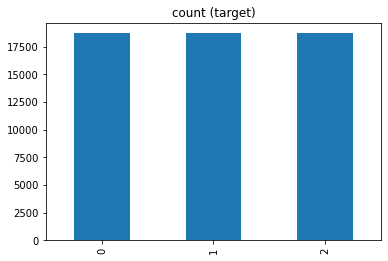

In [2]:
df = pd.read_csv ('Balanced_Visa_Data.csv')
df = df.sample(frac = 1) 
df['CASE_STATUS_CODE'].value_counts().plot(kind='bar', title='count (target)')

In [3]:
df1 = df.loc[(df['CASE_STATUS_CODE']==0) | (df['CASE_STATUS_CODE']==2)] 
df1['CASE_STATUS_CODE'] = np.select([df1.CASE_STATUS_CODE==0],[1],0)
np.unique(df1.CASE_STATUS_CODE)

array([0, 1])

<AxesSubplot:title={'center':'count (target)'}>

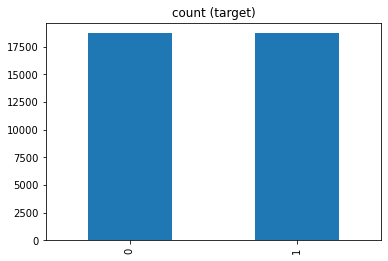

In [4]:
df1['CASE_STATUS_CODE'].value_counts().plot(kind='bar', title='count (target)')

#### Create Dummmies
At this point we are removing the categorical columns and replacing them with dummy variable that will 0,1 value for the model. Out target variable is 1 which means certified and 0 which specifies denied. In this phase we also removed some unnecesarry varibale incuding the unit of pay and wage unit of pay which specifies how the salary was recorded for an example weekly, bi-weekly monthly.

In [5]:
df2 = df1.drop(['CASE_STATUS','EMPLOYER_NAME_CODE', 'EMPLOYER_CITY_CODE',
           'SOC_NAME_CODE', 'EMPLOYER_STATE_CODE','WILLFUL_VIOLATOR_CODE',
           'AGENT_REPRESENTING_EMPLOYER_CODE', 'JOB_TITLE_CODE', 'EMPLOYER_STATE',
           'WORKSITE_CITY_CODE', 'WORKSITE_STATE_CODE', 'WORKSITE_STATE',
           'PW_UNIT_OF_PAY_CODE', 'PW_WAGE_LEVEL_CODE', 'WAGE_UNIT_OF_PAY_CODE',
           'H1B_DEPENDENT_CODE', 'SUPPORT_H1B_CODE', 'LABOR_CON_AGREE_CODE',
           'Unnamed: 0','WORKSITE_CITY','EMPLOYER_NAME','PW_UNIT_OF_PAY',
            'EMPLOYER_CITY','WILLFUL_VIOLATOR_CODE', 'WORKSITE_CITY_CODE',
            'SOC_GROUP_Code','SOC_NAME','JOB_TITLE','SOC_GROUP_CODE',
            'WAGE_UNIT_OF_PAY'], axis=1)

In [6]:
WILLFUL_VIOLATOR = pd.get_dummies(df2.WILLFUL_VIOLATOR, prefix='WILL_VIOL',drop_first=True)
df2 = pd.concat([df2, WILLFUL_VIOLATOR], axis=1)

SOC_GROUP = pd.get_dummies(df2['SOC_GROUP'],drop_first=True)
df2 = pd.concat([df2, SOC_GROUP], axis=1)

PW_WAGE_LEVEL = pd.get_dummies(df2.PW_WAGE_LEVEL, prefix='PW_LEVEL',drop_first=True)
df2 = pd.concat([df2, PW_WAGE_LEVEL], axis=1)

AGENT_REPRESENTING_EMPLOYER = pd.get_dummies(df2.AGENT_REPRESENTING_EMPLOYER, prefix='AGENT_REP',drop_first=True)
df2 = pd.concat([df2, AGENT_REPRESENTING_EMPLOYER], axis=1)  

H1B_DEPENDENT = pd.get_dummies(df2.H1B_DEPENDENT, prefix='H1B_DEP',drop_first=True)
df2 = pd.concat([df2, H1B_DEPENDENT], axis=1)

LABOR_CON_AGREE = pd.get_dummies(df2.LABOR_CON_AGREE, prefix='LABOR_CON_AGREE',drop_first=True)
df2 = pd.concat([df2, LABOR_CON_AGREE], axis=1)

SUPPORT_H1B = pd.get_dummies(df2.SUPPORT_H1B, prefix='SUPPORT_H1B',drop_first=True)
df2 = pd.concat([df2, SUPPORT_H1B], axis=1)

In [7]:
df2.shape

(37420, 42)

In [8]:
df3 = df2.drop(['WILLFUL_VIOLATOR','PW_WAGE_LEVEL',
               'H1B_DEPENDENT','LABOR_CON_AGREE',
                'AGENT_REPRESENTING_EMPLOYER','SOC_GROUP','SUPPORT_H1B'], axis=1)
df3.head()

,TOTAL_WORKERS,NEW_EMPLOYMENT,CONTINUED_EMPLOYMENT,CHANGE_PREVIOUS_EMPLOYMENT,NEW_CONCURRENT_EMPLOYMENT,ANNUALIZED_PREVAILING_WAGE,PREVAILING_WAGE,ANNUALIZED_WAGE_RATE_OF_PAY,WAGE_RATE_OF_PAY,DAYS_PROCESS,...,Management,Office and Administrative Support,Personal Care and Service,Production,Sales and Related,Transportation and Material Moving,AGENT_REP_Y,H1B_DEP_Y,LABOR_CON_AGREE_Y,SUPPORT_H1B_Y
38549,1,0,0,0,0,70020.301444,70020.301444,69934.141559,69934.141559,2,...,0,0,0,0,0,0,0,1,1,1
19612,1,0,0,0,0,68827.000000,68827.000000,67000.000000,67000.000000,3,...,0,0,0,0,0,0,0,1,1,1
54086,2,1,0,0,0,65179.112976,65179.112976,65179.112976,65179.112976,1,...,0,0,0,0,0,0,0,1,0,1
48152,4,1,0,0,0,73352.855482,73352.855482,73443.894544,73443.894544,4,...,0,0,0,0,0,0,0,0,1,1
38798,1,0,0,0,0,125025.069780,125025.069780,133871.424355,133871.424355,2,...,0,0,0,0,0,0,0,0,1,0


In [9]:
cont_vars = ['TOTAL_WORKERS','ANNUALIZED_PREVAILING_WAGE', 
           'PREVAILING_WAGE', 'ANNUALIZED_WAGE_RATE_OF_PAY',
                'WAGE_RATE_OF_PAY','DAYS_PROCESS']

In [10]:
pd.set_option('display.max_columns', 100)
df3.shape

(37420, 35)

In [11]:
df3.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 37420 entries, 38549 to 47069
Data columns (total 35 columns):
 #   Column                                          Non-Null Count  Dtype  
---  ------                                          --------------  -----  
 0   TOTAL_WORKERS                                   37420 non-null  int64  
 1   NEW_EMPLOYMENT                                  37420 non-null  int64  
 2   CONTINUED_EMPLOYMENT                            37420 non-null  int64  
 3   CHANGE_PREVIOUS_EMPLOYMENT                      37420 non-null  int64  
 4   NEW_CONCURRENT_EMPLOYMENT                       37420 non-null  int64  
 5   ANNUALIZED_PREVAILING_WAGE                      37420 non-null  float64
 6   PREVAILING_WAGE                                 37420 non-null  float64
 7   ANNUALIZED_WAGE_RATE_OF_PAY                     37420 non-null  float64
 8   WAGE_RATE_OF_PAY                                37420 non-null  float64
 9   DAYS_PROCESS                       

### SECTION 1 - CREATE MODELS:  Logistic Regression and SVM 

Preparing the training and testing subsets - - Scaling the data

The data is wide-spread for wage features, days processed and total workers, which will skew against the other features which are primarily yes/no.

Scaling the data brings all values onto one scale to minimize the effects of this.

In [12]:
# divide data set to x and y and Scale data

y = df3['CASE_STATUS_CODE']
x = df3.drop(['CASE_STATUS_CODE'], axis=1)

In [13]:
a = df3['CASE_STATUS_CODE'].values
bb = df3.drop(['CASE_STATUS_CODE'], axis=1)
b = bb.values

x_t = x[:7484]
y_t = y[:7484]

print(x_t.shape)
print(y_t.shape)

(7484, 34)
(7484,)


In [14]:
# create train set
import random
random.seed(0)
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.2, random_state=0)
print(y_train.shape)
print(x_test.shape)

(29936,)
(7484, 34)


### Logistic Regression


#### Running the Grid Search

In [15]:
def print_results(results):
    print('BEST PARAMS: {}\n'.format(results.best_params_))

    means = results.cv_results_['mean_test_score']
    stds = results.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, results.cv_results_['params']):
        print('{} (+/-{}) for {}'.format(round(mean, 3), round(std * 2, 3), params))

In [16]:
# grid search
params = {
    'penalty':['l2'],        # l1 is Lasso, l2 is Ridge
    'solver':['sag'],
    'C': [0.1,1,10,100]
}

lr = LogisticRegression()
lr_gs = GridSearchCV(lr, params, cv=5, verbose=1).fit(x_train, y_train)

print_results(lr_gs)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
BEST PARAMS: {'C': 0.1, 'penalty': 'l2', 'solver': 'sag'}

0.591 (+/-0.012) for {'C': 0.1, 'penalty': 'l2', 'solver': 'sag'}
0.591 (+/-0.012) for {'C': 1, 'penalty': 'l2', 'solver': 'sag'}
0.591 (+/-0.012) for {'C': 10, 'penalty': 'l2', 'solver': 'sag'}
0.591 (+/-0.012) for {'C': 100, 'penalty': 'l2', 'solver': 'sag'}


#### Logistic Regression Model

Applying a scale it to the entire data before splitting into training and test sets will bias the model evaluation because information would have leaked from the test set to the training set. scikit learn developers recommend using StandardScaler within a Pipeline in order to prevent most risks of data leaking: pipe = make_pipeline(StandardScaler(), LogisticRegression()).

In [17]:
# Create pipeline
pipe = Pipeline([
        ('scale', StandardScaler()),
        ('lg', LogisticRegression(penalty='l2',solver='sag', random_state=0,C=0.1))])
pipe.fit(x_train,y_train)

Pipeline(steps=[('scale', StandardScaler()),
                ('lg',
                 LogisticRegression(C=0.1, random_state=0, solver='sag'))])

#### 10 fold Cross Validation 

In [18]:
# cross validation
random.seed(10)
from sklearn.model_selection import ShuffleSplit
num_cv_iterations = 10
cv_object = ShuffleSplit(n_splits=num_cv_iterations,test_size  = 0.2)

In [19]:
# accuracies fom cross validation

from sklearn.model_selection import cross_val_score
accuracies = cross_val_score(pipe, x_t, y=y_t, cv=cv_object)
print(accuracies)

[0.85838343 0.83767535 0.81830327 0.82765531 0.83366733 0.84368737
 0.84034736 0.82030728 0.83433534 0.82832331]


In [20]:
pd.set_option('display.max_rows', None)
from sklearn import metrics as mt
iter_num=0
average_accuracy = []
average_precision = []
average_recall = []
average_f1_score=[]
average_matrix=[]

for iter_num, (train_indices, test_indices) in enumerate(cv_object.split(b,a)):
    pipe.fit(b[train_indices],a[train_indices])  # train object
    y_hat = pipe.predict(b[test_indices])
    average_accuracy.append(mt.accuracy_score(a[test_indices],y_hat))
    average_precision.append(mt.precision_score(a[test_indices],y_hat))
    average_recall.append(mt.recall_score(a[test_indices],y_hat))
    average_f1_score.append(mt.f1_score(a[test_indices],y_hat)) 
    average_matrix.append(mt.confusion_matrix(a[test_indices],y_hat))
    
    print("====Iteration",iter_num," ====")
    print("accuracy", mt.accuracy_score(a[test_indices],y_hat))
    print("precision", mt.precision_score(a[test_indices],y_hat)) 
    print("recall", mt.recall_score(a[test_indices],y_hat)) 
    print("f1-score", mt.f1_score(a[test_indices],y_hat))
    print("confusion matrix\n",mt.confusion_matrix(a[test_indices],y_hat))
#    print(classification_report(a[test_indices],y_hat))

====Iteration 0  ====
accuracy 0.8309727418492785
precision 0.8157031052764453
recall 0.8579394583112055
f1-score 0.836288339588456
confusion matrix
 [[2988  730]
 [ 535 3231]]
====Iteration 1  ====
accuracy 0.8397915553180118
precision 0.8291878172588832
recall 0.8613234906406538
f1-score 0.844950213371266
confusion matrix
 [[3018  673]
 [ 526 3267]]
====Iteration 2  ====
accuracy 0.8347140566541956
precision 0.8185308420783209
recall 0.8582930756843801
f1-score 0.8379405214201493
confusion matrix
 [[3049  709]
 [ 528 3198]]
====Iteration 3  ====
accuracy 0.8333778727952966
precision 0.8170699973978662
recall 0.8523344191096635
f1-score 0.8343297462468448
confusion matrix
 [[3097  703]
 [ 544 3140]]
====Iteration 4  ====
accuracy 0.8369855692143239
precision 0.8133333333333334
recall 0.8657205240174672
f1-score 0.8387096774193548
confusion matrix
 [[3092  728]
 [ 492 3172]]
====Iteration 5  ====
accuracy 0.8305718866916088
precision 0.8229140086756825
recall 0.8489076072650698
f1-scor

In [21]:
final_accuracy = sum(average_accuracy)/len(average_accuracy)
final_precision = sum(average_precision)/len(average_precision)
final_recall = sum(average_recall)/len(average_recall)
final_f1_score = sum(average_f1_score)/len(average_accuracy)
final_confusion_mat = sum(average_matrix)/len(average_matrix)

print("logistic regression averaged results")
print("average accuracy",final_accuracy)
print("average precision",final_precision)
print("average recall",final_recall)
print("average f1_score",final_f1_score)
print("confusion matrix\n",final_confusion_mat)

logistic regression averaged results
average accuracy 0.8336584714056654
average precision 0.8194387306783305
average recall 0.8561291520572196
average f1_score 0.8373619619400696
confusion matrix
 [[3034.1  706.2]
 [ 538.7 3205. ]]


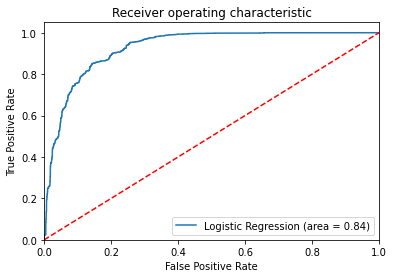

In [22]:
from matplotlib import pyplot as plt
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
logit_roc_auc = roc_auc_score(y_test, pipe.predict(x_test))
fpr, tpr, thresholds = roc_curve(y_test, pipe.predict_proba(x_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

### Support Vector Machines

In [23]:
# reducing data set size for SVC

df4=df3.sort_values(by=['CASE_STATUS_CODE'])
df4=df4.iloc[13000:, :]
df4=df4.iloc[:11420, :]
df4.shape

(11420, 35)

In [24]:
df4 = df4.sample(frac = 1) 
df4.head(5)

,TOTAL_WORKERS,NEW_EMPLOYMENT,CONTINUED_EMPLOYMENT,CHANGE_PREVIOUS_EMPLOYMENT,NEW_CONCURRENT_EMPLOYMENT,ANNUALIZED_PREVAILING_WAGE,PREVAILING_WAGE,ANNUALIZED_WAGE_RATE_OF_PAY,WAGE_RATE_OF_PAY,DAYS_PROCESS,CASE_STATUS_CODE,WILL_VIOL_Y,"Arts, Design, Entertainment, Sports, and Media",Building and Grounds Cleaning and Maintenance,Business and Financial Operations,Community and Social Service,Computer and Mathematical,Construction and Extraction,"Education, Training, and Library",Food Preparation and Serving Related,Healthcare Practitioners and Technical,Healthcare Support,"Installation, Maintenance, and Repair",Legal,"Life, Physical, and Social Science",Management,Office and Administrative Support,Personal Care and Service,Production,Sales and Related,Transportation and Material Moving,AGENT_REP_Y,H1B_DEP_Y,LABOR_CON_AGREE_Y,SUPPORT_H1B_Y
52604,1,0,0,0,0,94852.759620,94852.759620,109047.040989,109047.040989,2,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0
42159,1,0,0,0,0,76168.564873,36.619502,58642.046244,58642.046244,6,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1
14500,1,0,0,1,0,74818.000000,74818.000000,74818.000000,74818.000000,6,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1
55186,1,1,0,0,0,47304.114811,22.742363,46777.124289,22.489002,6,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1,1
8534,1,1,0,0,0,56285.000000,56285.000000,80000.000000,80000.000000,6,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1


<AxesSubplot:title={'center':'count (target)'}>

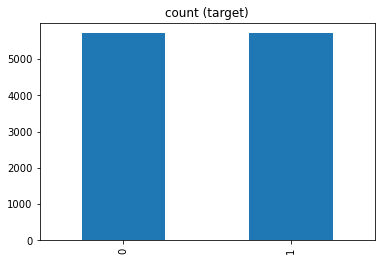

In [25]:
df4['CASE_STATUS_CODE'].value_counts().plot(kind='bar', title='count (target)')

In [26]:
from sklearn import svm

#### Test/Train Split for SVM 
The scikit learn SVC model classifier needs a smaller data set to function, due to the requirements of this lab and the capabilities of the scikitlearn model another test train split set has been created this will allow the support vectors to be accessed at the end of the lab.

In [27]:
# Reduced data set preprocessing for SVC
# divide data set to x and y and Scale data
#from sklearn import preprocessing

y = df4['CASE_STATUS_CODE']
x = df4.drop(['CASE_STATUS_CODE'], axis=1)
#x = preprocessing.scale(x) 

a = df4['CASE_STATUS_CODE'].values
bb = df4.drop(['CASE_STATUS_CODE'], axis=1)
b = bb.values
#b = preprocessing.scale(b) 

x_t = x[:2284]
y_t = y[:2284]

print(x.shape)
print(y.shape)

(11420, 34)
(11420,)


In [28]:
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.2, random_state=0)
print(y_train.shape)
print(x_test.shape)

(9136,)
(2284, 34)


In [29]:
# Grid search
svc = GridSearchCV(svm.SVC(gamma='auto',random_state=89),{
            'C':[1,10,100],
                'kernel':['rbf']}, cv=5, verbose=1,)

sv_gs = svc.fit(x_train, y_train)
print_results(sv_gs)

Fitting 5 folds for each of 3 candidates, totalling 15 fits
BEST PARAMS: {'C': 10, 'kernel': 'rbf'}

0.804 (+/-0.017) for {'C': 1, 'kernel': 'rbf'}
0.805 (+/-0.016) for {'C': 10, 'kernel': 'rbf'}
0.805 (+/-0.017) for {'C': 100, 'kernel': 'rbf'}


In [30]:
# Create pipeline
pipesv = Pipeline([
        ('scale', StandardScaler()),
        ('sv', svm.SVC(C=10,kernel= 'rbf',random_state=89))])
pipesv.fit(x_train,y_train)

Pipeline(steps=[('scale', StandardScaler()),
                ('sv', SVC(C=10, random_state=89))])

In [31]:
iter_num=0
ave_accuracy = []
ave_precision = []
ave_recall = []
ave_f1_score=[]
ave_matrix=[]

for iter_num, (train_indices, test_indices) in enumerate(cv_object.split(b,a)):
    pipesv.fit(b[train_indices],a[train_indices])  # train object
    y_hat = pipesv.predict(b[test_indices])
    ave_accuracy.append(mt.accuracy_score(a[test_indices],y_hat))
    ave_precision.append(mt.precision_score(a[test_indices],y_hat))
    ave_recall.append(mt.recall_score(a[test_indices],y_hat))
    ave_f1_score.append(mt.f1_score(a[test_indices],y_hat))
    ave_matrix.append(mt.confusion_matrix(a[test_indices],y_hat))
    
    print("====Iteration",iter_num," ====")
    print("accuracy", mt.accuracy_score(a[test_indices],y_hat)) 
    print("precision", mt.precision_score(a[test_indices],y_hat)) 
    print("recall", mt.recall_score(a[test_indices],y_hat)) 
    print("f1-score", mt.f1_score(a[test_indices],y_hat))
    print("confusion matrix\n",mt.confusion_matrix(a[test_indices],y_hat))
#    print(classification_report(a[test_indices],y_hat))

====Iteration 0  ====
accuracy 0.8822241681260946
precision 0.8521809369951535
recall 0.9246275197195443
f1-score 0.8869272803699033
confusion matrix
 [[ 960  183]
 [  86 1055]]
====Iteration 1  ====
accuracy 0.8809106830122592
precision 0.8477366255144033
recall 0.9221128021486124
f1-score 0.8833619210977701
confusion matrix
 [[ 982  185]
 [  87 1030]]
====Iteration 2  ====
accuracy 0.8739054290718039
precision 0.8387358184764991
recall 0.9208185053380783
f1-score 0.8778625954198472
confusion matrix
 [[ 961  199]
 [  89 1035]]
====Iteration 3  ====
accuracy 0.8804728546409807
precision 0.8486574450772986
recall 0.9230088495575222
f1-score 0.884272997032641
confusion matrix
 [[ 968  186]
 [  87 1043]]
====Iteration 4  ====
accuracy 0.8620840630472855
precision 0.8281758957654723
recall 0.9072256913470116
f1-score 0.8659003831417625
confusion matrix
 [[ 952  211]
 [ 104 1017]]
====Iteration 5  ====
accuracy 0.8835376532399299
precision 0.8473895582329317
recall 0.9328028293545535
f1-sco

In [32]:
fin_accuracy = sum(ave_accuracy)/len(ave_accuracy)
fin_precision = sum(ave_precision)/len(ave_precision)
fin_recall = sum(ave_recall)/len(ave_recall)
fin_f1_score = sum(ave_f1_score)/len(ave_accuracy)
fin_confusion_mat = sum(ave_matrix)/len(ave_matrix)

print('SVM averaged results')
print("average accuracy",fin_accuracy)
print("average precision",fin_precision)
print("average recall",fin_recall)
print("average f1_score",fin_f1_score)
print("confusion matrix\n",fin_confusion_mat)

SVM averaged results
average accuracy 0.8763134851138353
average precision 0.8454638918035796
average recall 0.9193519120581293
average f1_score 0.8808365752682606
confusion matrix
 [[ 957.3  190.9]
 [  91.6 1044.2]]


In [34]:
scaler = StandardScaler()
for train_indices, test_indices in cv_object.split(b,a):
    X_train = b[train_indices]
    y_train = a[train_indices]
    
    X_test = b[test_indices]
    y_test = a[test_indices]
    
X_train_scaled = scaler.fit_transform(X_train) # apply to training
X_test_scaled = scaler.fit_transform(X_test)

#### Assess how well each model performs

Logistic Regression, (run on the full dataset) had an overall accuracy average of 83.3%.   SVM (run on a subset of the data) had an overall accuracy average of 87.6%.  The other effectivenss measures are shown below.

Since SVM was run on a subset of the data we cannot come to the conclusion that it was a more effective model vs. Logistic Regression.

Based on the fact that we were able to use Logistic Regression on the full dataset, our preference is to use that model for the data. 

Logistic Regression Model Effectiveness Measures

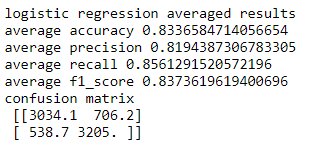

Support Vector Machines Effectiveness Measures

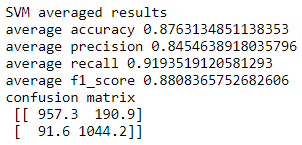

### SECTION 2 - MODEL ADVANTAGES

As stated above, Logistic Regression had an overall accuracy of 83% and SVM had an overall accuracy of 87%.

We were not able to run SVM on the full dataset.  Since the performance measures are based on a subset of the data we cannot come to the conclusion that it was a more effective model vs. Logistic Regression.

Logistic regression is preferred in cases of a binary outcome (T/F, Y/N) and the objective is to determine if a new sample fits best into a category as it is simpler and more efficient.  Examples of problems where logistic regression is applied include cancer detection (yes/no), test scores (pass/fail), marketing (customer will purchase or not).  

SVM is preferred for unstructured and semi-strutured data like text and images.  It is best when there is an understandable margin of dissociation between classes and is more efficient in high dimensional spaces or when the number of dimensions is larger than the number of specimans.

Based on the fact that we were able to use Logistic Regression on the full dataset, our preference is to use that model for the data.  The model was quick to run and we could interprate the results. We could not do this with the SVM Model. The logistic regression model not only provided a measure of how appropriate a feature was, but also provided the diretion of association so we could interpret the feature importance to the model.  

The downside in using Logistic Regression as opposed to SVM is that Logistic Regression is vulnerable to overfitting because it constructs linear boundaries, so that needs to be taken into account.  Since SVM tries to find the best margin, this reduces that risk.  However, we applied Lasso Regularization to avoid overfitting, so this is not enough of a reason to sway our decision on model appropriateness.  Finally, as we discovered, SVM algorithms are not acceptable for large data sets.  




### Section 3 -  Logistic Regression Weight Interpretation

In [35]:
# predictions for logistic regression
pd.set_option('display.max_rows', None)

lg = LogisticRegression(penalty='l2',solver='sag', random_state=0,C=0.1)
lg.fit(X_train_scaled, y_train)

y_pred = lg.predict(X_test)
coef = lg.coef_

coefs = []
for i in coef[0]:
    coefs.append(round(i,6))

In [36]:
coef = [i for i in coefs]
coef_abs = [abs(i) for i in coefs]
odds = [math.exp(i) for i in coef ]
scale = scaler.scale_
zip_vars = zip(coef,coef_abs,odds,scale,bb.columns) # combine attributes
zip_vars = sorted(zip_vars)

In [37]:
df_weights = pd.DataFrame(zip_vars, columns = ['coef','coef_abs','odds','std_dev','feature_names' ])

In [38]:
# features with highest weights
df_coef = df_weights[df_weights['coef_abs'] > 0.3]
df_coef

,coef,coef_abs,odds,std_dev,feature_names
0,-0.786417,0.786417,0.455474,2.210284,TOTAL_WORKERS
1,-0.559879,0.559879,0.571278,0.101968,Food Preparation and Serving Related
2,-0.531075,0.531075,0.587973,0.146329,Community and Social Service
3,-0.424827,0.424827,0.653883,0.085952,Construction and Extraction
4,-0.388260,0.388260,0.678236,0.069231,Legal
5,-0.371948,0.371948,0.689390,0.072293,Building and Grounds Cleaning and Maintenance
6,-0.338179,0.338179,0.713068,0.083404,"Installation, Maintenance, and Repair"
7,-0.326962,0.326962,0.721111,0.062649,Healthcare Support
28,0.351515,0.351515,1.421219,0.569769,CONTINUED_EMPLOYMENT
29,0.371945,0.371945,1.450553,0.338734,SUPPORT_H1B_Y


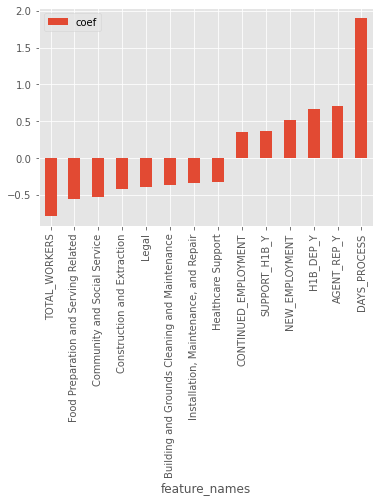

In [39]:
from matplotlib import pyplot as plt
%matplotlib inline
plt.style.use('ggplot')


ax = df_coef.plot.bar(y='coef', x = 'feature_names')
plt.show()

The dependent variable of logistic regression is binary and the “log-odds” of the dependent variable’s probability is modeled by a linear combination of independent variables:
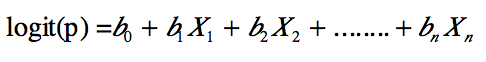
The logit function is defined as the logged odds of probability p:


The odds of an event is the probability of it happens over the probability of it doesn’t happen.<br>
The above variables show the features with the highest weights (coefficients), our target variables are certified = 1, denied=0, our model has been validated using cross-validation to check for overfitting.<br>

### Binary Variables
Most of the prominent weights were from the binary variables the only features that were continuous from the above table was the TOTAL_WORKERS and DAYS_PROCESS.<br>
Based on magnitude of the coefficient one of the largest  binary coefficient is the SOC_GROUP categorical variable of community and social service which tells us if the person being applied for was for this feild of work. It has a coefficient of -0.5920 which means providing all the other metrics are the same, and flipping the SOC_GROUP from Community and Social Service to NOT Community and Social Service, the log-odds of getting certified will decrease by 0.5920.
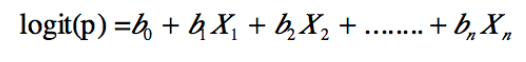

To convert log-odds to odds, we want to take the exponential on both sides of equation which results in the ratio of the odds being 0.507.
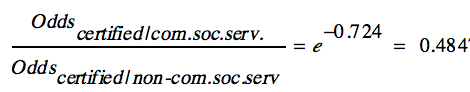
the coefficient of the SOC_GROUP categorical variable community and social service being -0.5920 can be interpreted as the odds of application for an employee in the feild community and social service getting certified over the odds of an applicant that is not in that feild is 0.5531 with all the other variables fixed. In terms of percentage change, the odds community and social service getting certified are xx% lower than the odds for applicant that is not in that feild to get certified this tells us that if if a company wants to appply for such a candidate they may less likely get their candidate certified

### Continuous variables (Standardised)

One common pre-processing step when performing logistic regression is to scale the independent variables to the same level (zero mean and unit variance). The motivation of this type of scaling, named standardization, is to make the feature coefficient scales comparable with each other.<br>
<br>To get the standardized coefficients back to odds ratio with interpretable units we convert the standardized unit back to the original unit of the feature. The most prominent continuous variable in our study is DAYS_PROCESS with standard deviation of 1.66 from the table value called std_dev from the scaling algorithm, and the fitted logistic regression gives this feature a standardized coefficient of 1.9421. This means by increasing one standardized unit of DAYS_PROCESS, the odds ratio of getting certified is exp(1.9421) = 6.9734 (i.e. the odds of getting certified increase by 597.34%).<br>
<br>From the scaling transformation we know that one standardized unit of age equals to 1.66 days, which is the standard deviation of days before the transformation. Plugging this information back, we can conclude that increasing the DAYS_PROCESS by 1.66 days will lead to an increase of odds of getting certified by 597.34%.

#### Feature Importance

Days_Process positively impacts obtaining a certified status for an application.  This is reasonable as a longer review period could indicate issues with the appliacation or those requiring in-depth review as it may not meet the criteria for certification. These criteria include specialty occupation, wage rate lower than prevailing wage or wage level classification not aligned with complexity of role. 

Agent_Rep_Y we would expect that applications that had legal involvement would have improved chances of being certified based on an attorney's understanding of the legal process involved in obtaining a Visa.

H1B_Dep_Y also has a larger impact on a certification result. This feature denotes that this is an employer who hires ‘too many’ H1B workers.  An H1B dependent employer is subject to additional attestation and paperwork requirements when filing for an H1B in an effort to protect U.S. workers. (https://www.visapro.com/resources/article/h1b-dependent-employer/)

Agent_Rep_Y we would expect that applications that had legal involvement would have improved chances of being certified based on an attorney's understanding of the legal process involved in obtaining a Visa.

New_Employment This suggests that it is easier to get an application certified if it isa new application vs. an extension under recertification.

Total_Workers had the largest negative impact. Since this is a continuous variable, we need to investigate this further in order to determine if applications with more or less headcount impacts this.

From an Occupation Group perspective, those with the most negative impact were Food Preparation/Serving Related, Community/Social Services, Construction and Extraction, & Building Grounds & Construction.  This is also reasonable as one of the criteria for certification are specialized occupations.

#### Other prominent Interpretations

In [40]:
cont_vars = ['TOTAL_WORKERS','ANNUALIZED_PREVAILING_WAGE', 
           'PREVAILING_WAGE', 'ANNUALIZED_WAGE_RATE_OF_PAY',
                'WAGE_RATE_OF_PAY','DAYS_PROCESS']

feat = list(df_coef['feature_names'])
ods = list(df_coef['odds'])
cofs = list(df_coef['coef'])
inter = zip(ods,feat,cofs)

for ods,feature,cof in inter:
    od = round((ods*100)-100,2)
    if  cof >0 and feature not in cont_vars:
        print('The odds of',feature,'getting certified over the alternative is', od,'%')

The odds of CONTINUED_EMPLOYMENT getting certified over the alternative is 42.12 %
The odds of SUPPORT_H1B_Y getting certified over the alternative is 45.06 %
The odds of NEW_EMPLOYMENT getting certified over the alternative is 68.69 %
The odds of H1B_DEP_Y getting certified over the alternative is 94.93 %
The odds of AGENT_REP_Y getting certified over the alternative is 102.68 %


In [41]:
feat = list(df_coef['feature_names'])
ods = list(df_coef['odds'])
cofs = list(df_coef['coef'])
scale = list(round(df_coef['std_dev'],4))
inter = zip(ods,feat,cofs,scale)

for ods,feature,cof,scale in inter:
    od = round((ods*100)-100,2)
    if  od >0 and feature in cont_vars:
        print('Increasing the',feature, 'by' ,scale, 'will lead to an increase of odds of getting certified by', od,'%')

Increasing the DAYS_PROCESS by 1.6611 will lead to an increase of odds of getting certified by 565.69 %


https://medium.com/axum-labs/logistic-regression-vs-support-vector-machines-svm-c335610a3d16

https://www.geeksforgeeks.org/advantages-and-disadvantages-of-logistic-regression/?ref=rp

https://www.geeksforgeeks.org/support-vector-machine-algorithm/?ref=rp

https://sciphy-stats.com/post/interpreting-logistic-regression-coefficients-odds-ratios/

### SECTION 4 - Support Vectors Interpretation

In [42]:
scaler = StandardScaler()
for train_indices, test_indices in cv_object.split(b,a):
    X_train = b[train_indices]
    y_train = a[train_indices]
    
    X_test = b[test_indices]
    y_test = a[test_indices]
    
X_train_scaled = scaler.fit_transform(X_train) # apply to training
X_test_scaled = scaler.fit_transform(X_test)

In [43]:
svmc = svm.SVC(C=100,kernel= 'rbf',random_state=89)
svmc.fit(X_train_scaled, y_train)

SVC(C=100, random_state=89)

In [44]:
# Get support vectors themselves
support_vectors = svmc.support_vectors_

# Visualize support vectors
#plt.scatter(x_train[:,7], x_train[:,6])
#plt.scatter(support_vectors[:,7], support_vectors[:,6], color='green')
#plt.title('Linearly separable data with support vectors')
#plt.xlabel('X1')
#plt.ylabel('X2')
#plt.show()

In [45]:
# to call the suppport vector foe each variable use the [column index]

svc = svmc.support_vectors_

# look at the support vectors
print(svmc.support_vectors_.shape)
print(svmc.support_.shape)
print(svmc.n_support_ )

(2552, 34)
(2552,)
[1266 1286]


In [46]:
df_test =  df4.iloc[train_indices].copy()
df_support = df_test.iloc[svmc.support_,:].copy()

df_support['CASE_STATUS_CODE'] = a[svmc.support_]

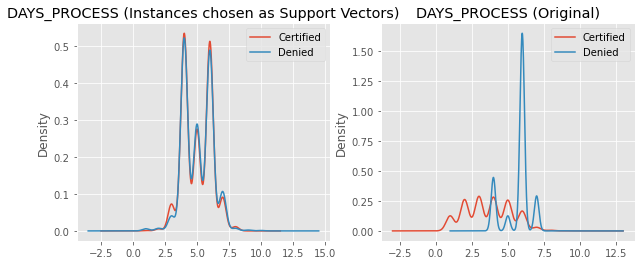

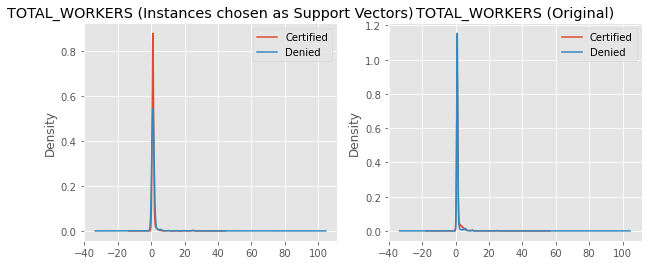

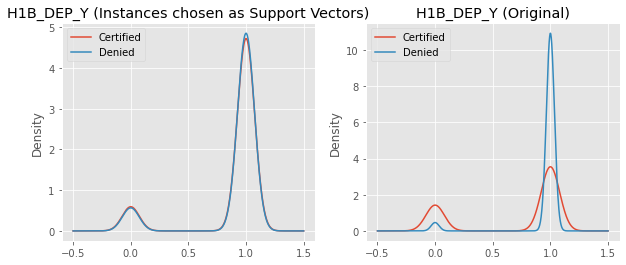

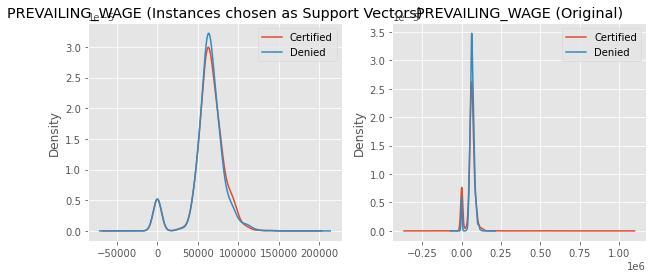

In [47]:
df_grouped_support = df_support.groupby(['CASE_STATUS_CODE'])
df_grouped = df4.groupby(['CASE_STATUS_CODE'])

# plot KDE of Different variables
vars_to_plot = ['DAYS_PROCESS','TOTAL_WORKERS','H1B_DEP_Y','PREVAILING_WAGE']

for v in vars_to_plot:
    plt.figure(figsize=(10,4))
    # plot support vector stats
    plt.subplot(1,2,1)
    ax = df_grouped_support[v].plot.kde() 
    plt.legend(['Certified','Denied'])
    plt.title(v+' (Instances chosen as Support Vectors)')
    
    # plot original distributions
    plt.subplot(1,2,2)
    ax = df_grouped[v].plot.kde() 
    plt.legend(['Certified','Denied'])
    plt.title(v+' (Original)')

https://medium.com/ro-data-team-blog/interpret-the-impact-size-with-logistic-regression-coefficients-5eec21baaac8

The support vector analysis shows the original statistics of these variables as well as the statistics of the support vectors.  

Days_Process & H1B_Dep
The separation in distribution of the original data is very distinct.  This is not the case with the support vectors for the certified class for Days_Process & H1B_Dep.  This indicates that they are close to the class boundary resulting in a distribution separation that is not as large and indicates that these cases have been missclassified.  

Total_Workers & Prevailing_Wage
The support vectors follow the distribution of the original data. However, they do appear to overstate the certified category and did not do well in preserving the orginal data integrity.

#### Exceptional Work

We are requesting consideration for exceptional points as our group is now down to 2 people with the departure of Senthil Kumar